In [4]:
import os
import sys 
import glob
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import unicodedata
import string 
import copy

# 1.Load Data

In [5]:
data_folder = os.path.join("storage", "data", "language-words")
file_paths = glob.glob(os.path.join(data_folder, "*.txt"))
print(file_paths)

['storage\\data\\language-words\\Arabic.txt', 'storage\\data\\language-words\\Chinese.txt', 'storage\\data\\language-words\\Czech.txt', 'storage\\data\\language-words\\Dutch.txt', 'storage\\data\\language-words\\English.txt', 'storage\\data\\language-words\\French.txt', 'storage\\data\\language-words\\German.txt', 'storage\\data\\language-words\\Greek.txt', 'storage\\data\\language-words\\Irish.txt', 'storage\\data\\language-words\\Italian.txt', 'storage\\data\\language-words\\Japanese.txt', 'storage\\data\\language-words\\Korean.txt', 'storage\\data\\language-words\\Polish.txt', 'storage\\data\\language-words\\Portuguese.txt', 'storage\\data\\language-words\\Russian.txt', 'storage\\data\\language-words\\Scottish.txt', 'storage\\data\\language-words\\Spanish.txt', 'storage\\data\\language-words\\Vietnamese.txt']


In [6]:
words_dict = {}
for file_path in file_paths:
    language = file_path.split('\\')[3][:-4]
    with open(file_path, "r") as file:
        words = file.readlines()
        words = [word.strip().lower() for word in words]
        words_dict[language] = words

print(words_dict['German'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']


# 2. Clean Text

In [7]:
characters = set()
for language, words in words_dict.items():
    for word in words:
        characters.update(list(word))

characters = sorted(list(characters))
print(characters)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'õ', 'ö', 'ù', 'ú', 'ü', 'ą', 'ł', 'ń', 'ś', 'ż']


In [8]:
c = list('ñ')
c_normalized = list(unicodedata.normalize("NFD", 'ñ'))
print(c, c_normalized)

['ñ'] ['n', '̃']


In [9]:
characters_normalized = []
for character in characters:
    character_normalized = unicodedata.normalize("NFD", character)[0]
    characters_normalized.append(character_normalized)
print(characters_normalized)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'a', 'a', 'a', 'a', 'c', 'e', 'e', 'e', 'i', 'i', 'n', 'o', 'o', 'o', 'o', 'u', 'u', 'u', 'a', 'ł', 'n', 's', 'z']


In [10]:
characters_all = list(string.ascii_lowercase + " -',:;")
print(len(characters_all), characters_all)

32 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '-', "'", ',', ':', ';']


In [11]:
def clean_word(word):
    cleaned_word = ""
    for character in word:
        for character_raw in unicodedata.normalize("NFD", character):
            if character_raw in characters_all:
                cleaned_word += character_raw
    return cleaned_word
            

In [12]:
words_dict_cleaned = {}
for language, words in words_dict.items():
    cleaned_words = []
    print(language)
    for word in words:
        cleaned_word = clean_word(word)
        cleaned_words.append(cleaned_word)
    words_dict_cleaned[language] = cleaned_words


Arabic
Chinese
Czech
Dutch
English
French
German
Greek
Irish
Italian
Japanese
Korean
Polish
Portuguese
Russian
Scottish
Spanish
Vietnamese


In [13]:
print(words_dict['German'][-10:])
print(words_dict_cleaned['German'][-10:])
print(words_dict['Portuguese'][-10:])
print(words_dict_cleaned['Portuguese'][-10:])
print(words_dict['Polish'][-10:])
print(words_dict_cleaned['Polish'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['wolter', 'worner', 'wornhor', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['santos', 'serafim', 'silva', 'silveira', 'simões', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['santos', 'serafim', 'silva', 'silveira', 'simoes', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['wyrick', 'wyrzyk', 'zabek', 'zawisza', 'zdunowski', 'zdunowski', 'zielinski', 'ziemniak', 'zientek', 'żuraw']
['wyrick', 'wyrzyk', 'zabek', 'zawisza', 'zdunowski', 'zdunowski', 'zielinski', 'ziemniak', 'zientek', 'zuraw']


In [14]:
words_dict = copy.deepcopy(words_dict_cleaned)
del words_dict_cleaned

# 3. Define Utilities

In [15]:
num_langs = len(words_dict.keys())
num_chars = len(characters_all)
print(num_langs, num_chars)

18 32


In [16]:
max_timesteps = 0 
for language, words in words_dict.items():
    for word in words:
        if len(word) > max_timesteps:
            max_timesteps = len(word)
print(max_timesteps)

20


In [17]:
lang_to_id = {k:v for k,v in zip((sorted(list(words_dict.keys()))), range(len(words_dict.keys())))}
print(lang_to_id)

{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}


In [18]:
id_to_lang = {v:k for k,v in lang_to_id.items()}
print(id_to_lang)

{0: 'Arabic', 1: 'Chinese', 2: 'Czech', 3: 'Dutch', 4: 'English', 5: 'French', 6: 'German', 7: 'Greek', 8: 'Irish', 9: 'Italian', 10: 'Japanese', 11: 'Korean', 12: 'Polish', 13: 'Portuguese', 14: 'Russian', 15: 'Scottish', 16: 'Spanish', 17: 'Vietnamese'}


In [19]:
char_to_id = {k:v for k,v in zip(characters_all, range(len(characters_all)))}
print(char_to_id)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, '-': 27, "'": 28, ',': 29, ':': 30, ';': 31}


In [20]:
id_to_char = {v:k for k,v in char_to_id.items()}
print(id_to_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '-', 28: "'", 29: ',', 30: ':', 31: ';'}


# 4. Split Data

In [21]:
words_df = []
for language, words in tqdm(words_dict.items()):
    for word in words:
        words_df.append({"word": word, "language": language})
words_df = pd.DataFrame(words_df)
print(words_df.shape)
words_df.head()

  0%|          | 0/18 [00:00<?, ?it/s]

(20074, 2)


,word,language
0,khoury,Arabic
1,nahas,Arabic
2,daher,Arabic
3,gerges,Arabic
4,nazari,Arabic


In [22]:
words_df_train, words_df_test = train_test_split(words_df, train_size=0.8, stratify= words_df['language'], random_state=0)
words_df_train = words_df_train.reset_index(drop=True)
words_df_test = words_df_test.reset_index(drop=True)
print(words_df_train.shape)
print(words_df_test.shape)

(16059, 2)
(4015, 2)


In [23]:
train_count = words_df_train['language'].value_counts().rename("Train")
test_count = words_df_test['language'].value_counts().rename("Test")
count = pd.concat([train_count, test_count], axis=1, sort=True).T
count.loc["Total", :] = count.sum(axis=0)
count.loc[:, "Total"] = count.sum(axis=1)
count = count.astype("int")
count

language,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese,Total
Train,1600,214,415,238,2934,222,579,163,186,567,793,75,111,59,7526,80,238,59,16059
Test,400,54,104,59,734,55,145,40,46,142,198,19,28,15,1882,20,60,14,4015
Total,2000,268,519,297,3668,277,724,203,232,709,991,94,139,74,9408,100,298,73,20074


# 5. Define Dataset

In [24]:
class WordDataset(Dataset):
    def __init__(self, words_df):
        self.words_df = words_df

    def __len__(self):
        self.len = len(self.words_df)
        return self.len
    
    def __getitem__(self, idx):
        row = self.words_df.iloc[idx, :]
        word = row["word"].ljust(max_timesteps)
        x = torch.zeros((max_timesteps, num_chars))
        for i, char in enumerate(word):
            x[i, char_to_id[char]] = 1
        y = lang_to_id[row["language"]]

        return x,y

In [25]:
train_set = WordDataset(words_df_train)
test_set = WordDataset(words_df_test)

# 6. Define DataLoader

In [26]:
train_batch_size = 128
test_batch_size = 4

In [27]:
num_cpus = os.cpu_count()
print(num_cpus)

8


In [28]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [29]:
train_iter = iter(train_loader)
X,Y = next(train_iter)
print(X.size(), Y.size())

torch.Size([128, 20, 32]) torch.Size([128])


In [30]:
len_train_loader = len(train_loader)
print(len_train_loader)

126


# 7. Define Model

In [31]:
hidden_size = 24
num_layers = 2

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [33]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
        c0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
        out, ht = self.lstm1(X, (h0,c0))
        outn = out[:, -1, :]
        outn = outn.contiguous().view(batch_size, self.hidden_size)
        outn = self.fc2(outn)
        return outn

In [34]:
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (lstm1): LSTM(32, 24, num_layers=2, batch_first=True)
    (fc2): Linear(in_features=24, out_features=18, bias=True)
  )
)


In [35]:
for p in model.parameters():
    print(p.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


# 8. Set Optimizer

In [36]:
lr = 0.01
step_size = len_train_loader * 4
gamma = 0.95
print(step_size)

504


In [37]:
alpha = 0.6
weights = len(words_df_train) / (words_df_train["language"].value_counts() ** alpha)
weights = weights / weights.sum()
weights = weights.sort_index()
print(weights)

language
Arabic        0.016187
Chinese       0.054123
Czech         0.036375
Dutch         0.050779
English       0.011250
French        0.052944
German        0.029787
Greek         0.063726
Irish         0.058874
Italian       0.030163
Japanese      0.024664
Korean        0.101530
Polish        0.080249
Portuguese    0.117252
Russian       0.006393
Scottish      0.097673
Spanish       0.050779
Vietnamese    0.117252
Name: count, dtype: float64


In [38]:
weights = torch.Tensor(weights).to(device)
print(weights)

tensor([0.0162, 0.0541, 0.0364, 0.0508, 0.0113, 0.0529, 0.0298, 0.0637, 0.0589,
        0.0302, 0.0247, 0.1015, 0.0802, 0.1173, 0.0064, 0.0977, 0.0508, 0.1173],
       device='cuda:0')


In [39]:
criterion = nn.CrossEntropyLoss(weight=weights, reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

# 9. Train Model

In [40]:
epochs = 100
print_every_n_epochs = 1

In [41]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0
    for X, Y in tqdm(train_loader, desc=f"Epoch-{epoch}"):
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)

    if epoch % print_every_n_epochs == 0:
        message = f"Epoch:{epoch}     Loss:{epoch_loss}      LR:{epoch_lr}"
        print(message)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/126 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\Dekalog\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch:1     Loss:2.7297781989687966      LR:0.010000000000000007


Epoch-2:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:2     Loss:2.657938304401579      LR:0.010000000000000007


Epoch-3:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:3     Loss:2.3615665256030978      LR:0.010000000000000007


Epoch-4:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:4     Loss:2.2048287306513106      LR:0.009992261904761912


Epoch-5:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:5     Loss:2.113771411161574      LR:0.009499999999999993


Epoch-6:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:6     Loss:1.9227132229577928      LR:0.009499999999999993


Epoch-7:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:7     Loss:1.7575710264463273      LR:0.009499999999999993


Epoch-8:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:8     Loss:1.6539220516643827      LR:0.009492648809523803


Epoch-9:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:9     Loss:1.5682377607103377      LR:0.009024999999999986


Epoch-10:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:10     Loss:1.5377758438625033      LR:0.009024999999999986


Epoch-11:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:11     Loss:1.4825405081113179      LR:0.009024999999999986


Epoch-12:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:12     Loss:1.4353222175249978      LR:0.009018016369047605


Epoch-13:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:13     Loss:1.3934555526763674      LR:0.008573750000000022


Epoch-14:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:14     Loss:1.3742344909244113      LR:0.008573750000000022


Epoch-15:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:15     Loss:1.331934629451661      LR:0.008573750000000022


Epoch-16:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:16     Loss:1.3055720646230002      LR:0.00856711555059526


Epoch-17:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:17     Loss:1.2778904485324072      LR:0.008145062500000013


Epoch-18:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:18     Loss:1.2839323504576607      LR:0.008145062500000013


Epoch-19:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:19     Loss:1.220367517736223      LR:0.008145062500000013


Epoch-20:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:20     Loss:1.2131419919786      LR:0.008138759773065489


Epoch-21:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:21     Loss:1.194190583058766      LR:0.00773780937500001


Epoch-22:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:22     Loss:1.1654981682224879      LR:0.00773780937500001


Epoch-23:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:23     Loss:1.1383110005704185      LR:0.00773780937500001


Epoch-24:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:24     Loss:1.1232325898276434      LR:0.007731821784412213


Epoch-25:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:25     Loss:1.1025108510539645      LR:0.007350918906249978


Epoch-26:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:26     Loss:1.0846021709934113      LR:0.007350918906249978


Epoch-27:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:27     Loss:1.078676949890833      LR:0.007350918906249978


Epoch-28:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:28     Loss:1.0474484752094935      LR:0.0073452306951915704


Epoch-29:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:29     Loss:1.03255818713279      LR:0.00698337296093751


Epoch-30:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:30     Loss:1.0148729667777108      LR:0.00698337296093751


Epoch-31:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:31     Loss:1.033242047306091      LR:0.00698337296093751


Epoch-32:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:32     Loss:0.9931942654980553      LR:0.006977969160432022


Epoch-33:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:33     Loss:0.9671537322657449      LR:0.006634204312890632


Epoch-34:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:34     Loss:0.9577547959865086      LR:0.006634204312890632


Epoch-35:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:35     Loss:0.9808132733617511      LR:0.006634204312890632


Epoch-36:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:36     Loss:0.9462033727812389      LR:0.006629070702410419


Epoch-37:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:37     Loss:0.9351366630622319      LR:0.006302494097246071


Epoch-38:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:38     Loss:0.9228038877721817      LR:0.006302494097246071


Epoch-39:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:39     Loss:0.920873441866466      LR:0.006302494097246071


Epoch-40:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:40     Loss:0.8896173416149049      LR:0.006297617167289869


Epoch-41:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:41     Loss:0.9053911703919607      LR:0.005987369392383785


Epoch-42:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:42     Loss:0.8761482399607462      LR:0.005987369392383785


Epoch-43:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:43     Loss:0.8648923521950131      LR:0.005987369392383785


Epoch-44:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:44     Loss:0.8552545233378335      LR:0.005982736308925393


Epoch-45:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:45     Loss:0.8553946297320109      LR:0.005688000922764589


Epoch-46:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:46     Loss:0.854568851845605      LR:0.005688000922764589


Epoch-47:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:47     Loss:0.837064771898209      LR:0.005688000922764589


Epoch-48:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:48     Loss:0.8392690614102378      LR:0.005683599493479116


Epoch-49:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:49     Loss:0.8504334506061342      LR:0.005403600876626381


Epoch-50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:50     Loss:0.8278559297323227      LR:0.005403600876626381


Epoch-51:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:51     Loss:0.802569425531796      LR:0.005403600876626381


Epoch-52:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:52     Loss:0.8060649437090707      LR:0.005399419518805181


Epoch-53:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:53     Loss:0.7900183929337395      LR:0.005133420832795042


Epoch-54:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:54     Loss:0.7864357207029585      LR:0.005133420832795042


Epoch-55:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:55     Loss:0.7719638995707981      LR:0.005133420832795042


Epoch-56:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:56     Loss:0.7811477579294689      LR:0.005129448542864903


Epoch-57:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:57     Loss:0.7538726353456103      LR:0.004876749791155301


Epoch-58:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:58     Loss:0.7647677345408334      LR:0.004876749791155301


Epoch-59:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:59     Loss:0.7457822282162924      LR:0.004876749791155301


Epoch-60:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:60     Loss:0.7518362745879188      LR:0.004872976115721669


Epoch-61:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:61     Loss:0.7476391983883721      LR:0.004632912301597531


Epoch-62:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:62     Loss:0.7578474049057279      LR:0.004632912301597531


Epoch-63:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:63     Loss:0.7293131334914101      LR:0.004632912301597531


Epoch-64:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:64     Loss:0.7374989265014255      LR:0.004629327309935581


Epoch-65:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:65     Loss:0.7109634552210097      LR:0.004401266686517646


Epoch-66:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:66     Loss:0.7061975598335266      LR:0.004401266686517646


Epoch-67:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:67     Loss:0.7157601016381431      LR:0.004401266686517646


Epoch-68:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:68     Loss:0.7160670452174687      LR:0.004397860944438793


Epoch-69:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:69     Loss:0.6982543513415351      LR:0.004181203352191782


Epoch-70:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:70     Loss:0.6985115477490047      LR:0.004181203352191782


Epoch-71:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:71     Loss:0.6802945707052473      LR:0.004181203352191782


Epoch-72:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:72     Loss:0.6758551895618439      LR:0.004177967897216871


Epoch-73:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:73     Loss:0.6634765855140157      LR:0.003972143184582177


Epoch-74:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:74     Loss:0.6853553416236998      LR:0.003972143184582177


Epoch-75:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:75     Loss:0.6708230489776248      LR:0.003972143184582177


Epoch-76:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:76     Loss:0.6746908092782611      LR:0.003969069502356013


Epoch-77:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:77     Loss:0.6636703142098018      LR:0.0037735360253530743


Epoch-78:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:78     Loss:0.6479615318396735      LR:0.0037735360253530743


Epoch-79:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:79     Loss:0.6504113435272186      LR:0.0037735360253530743


Epoch-80:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:80     Loss:0.6639212821684186      LR:0.003770616027238218


Epoch-81:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:81     Loss:0.6499372919400533      LR:0.0035848592240854136


Epoch-82:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:82     Loss:0.6270304795295473      LR:0.0035848592240854136


Epoch-83:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:83     Loss:0.6297148520511294      LR:0.0035848592240854136


Epoch-84:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:84     Loss:0.6390951505256077      LR:0.0035820852258763


Epoch-85:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:85     Loss:0.6194112551590752      LR:0.0034056162628811576


Epoch-86:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:86     Loss:0.6138607994431541      LR:0.0034056162628811576


Epoch-87:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:87     Loss:0.6187442654655093      LR:0.0034056162628811576


Epoch-88:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:88     Loss:0.6031516433235199      LR:0.0034029809645824993


Epoch-89:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:89     Loss:0.6166123430880289      LR:0.003235335449737087


Epoch-90:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:90     Loss:0.6032080092127361      LR:0.003235335449737087


Epoch-91:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:91     Loss:0.5993692089640905      LR:0.003235335449737087


Epoch-92:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:92     Loss:0.607174738532021      LR:0.0032328319163533624


Epoch-93:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:93     Loss:0.5981452606973194      LR:0.0030735686772502303


Epoch-94:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:94     Loss:0.589634727627512      LR:0.0030735686772502303


Epoch-95:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:95     Loss:0.5958811870170018      LR:0.0030735686772502303


Epoch-96:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:96     Loss:0.5849913765513708      LR:0.0030711903205356914


Epoch-97:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:97     Loss:0.5864431545847938      LR:0.0029198902433877306


Epoch-98:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:98     Loss:0.5735746487265542      LR:0.0029198902433877306


Epoch-99:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:99     Loss:0.5915320886979027      LR:0.0029198902433877306


Epoch-100:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:100     Loss:0.566426126493348      LR:0.0029176308045089183


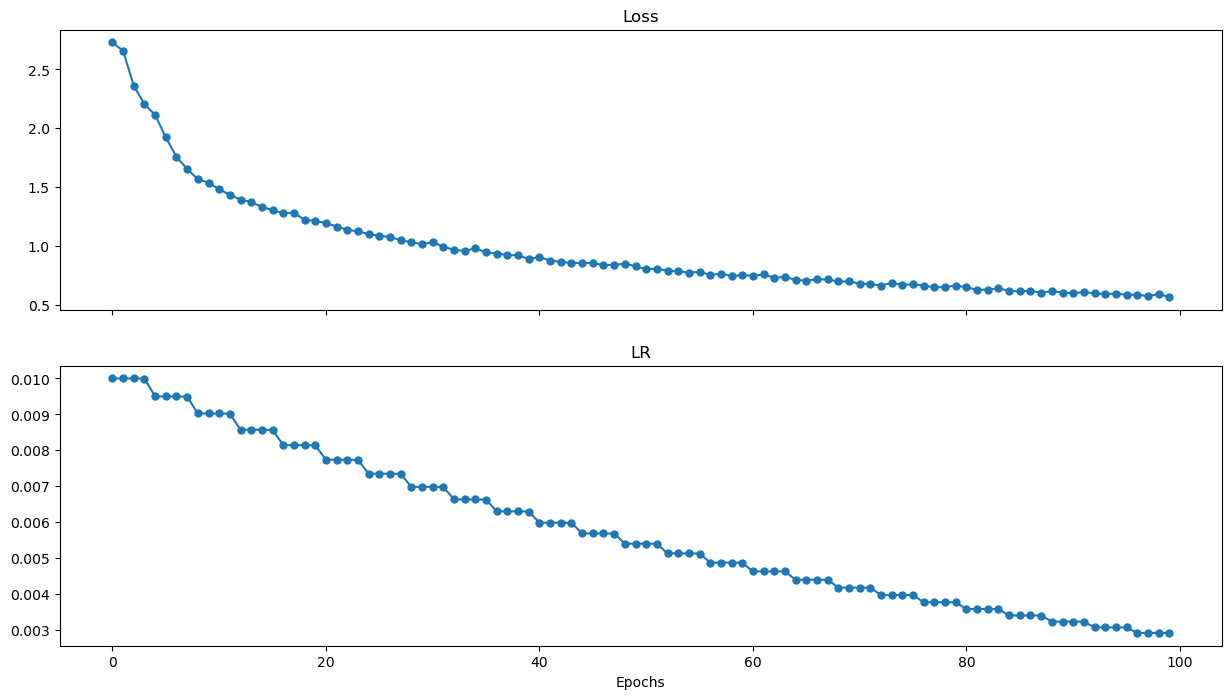

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

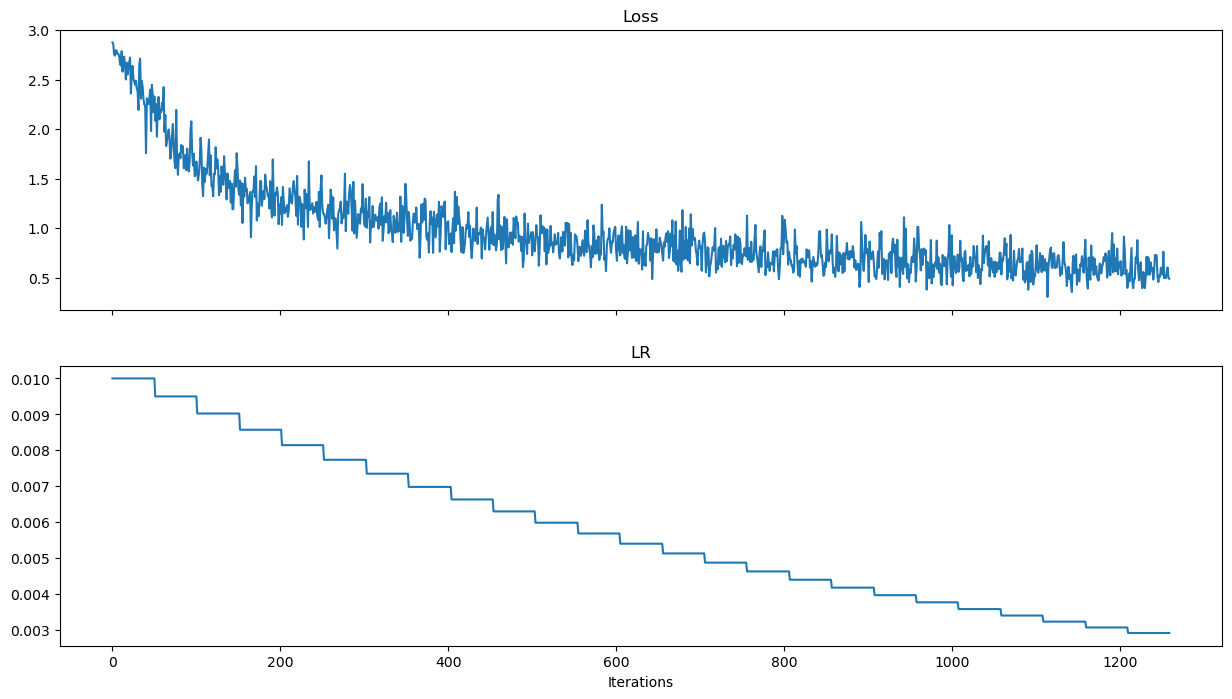

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.plot(iteration_losses[::10])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::10])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

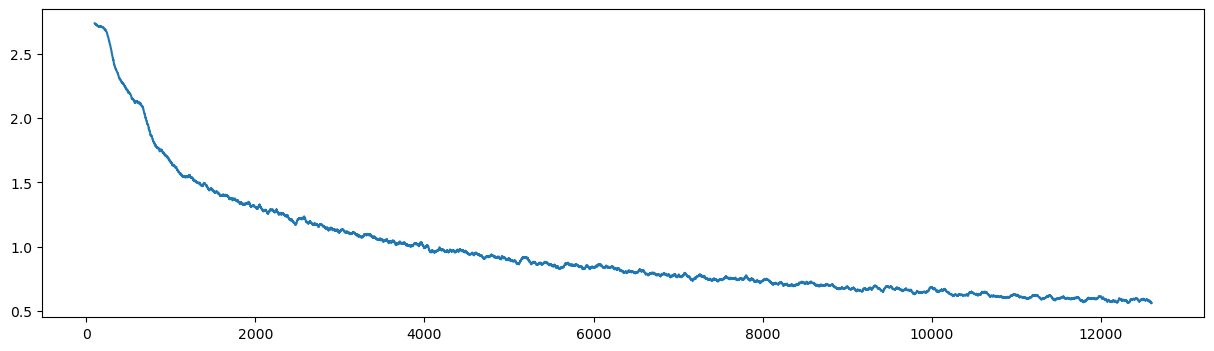

In [44]:
window = 100
plt.figure(figsize=(15, 4))
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [45]:
path = os.path.join("storage", "models", "language-words", "classifier.pth")
torch.save(model.state_dict(), path)

# 10. Test Model

In [46]:
path = os.path.join("storage", "models", "language-words", "classifier.pth")
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [47]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/126 [00:00<?, ?it/s]

In [48]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/1004 [00:00<?, ?it/s]

In [49]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.8318077090727941
Test Accuracy: 0.7297633872976339


In [50]:
mat = np.array([1, 2, 3])
print(mat.shape)
print(mat[:, np.newaxis].shape)

(3,)
(3, 1)


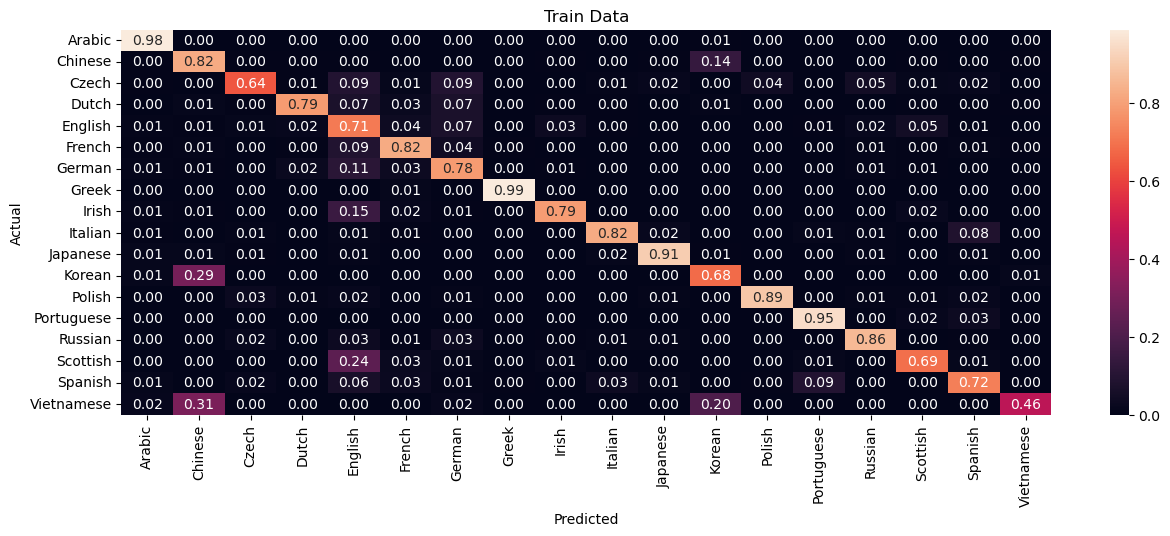

In [51]:
labels = sorted(list(lang_to_id.keys()))
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
c_mat_train = c_mat_train / c_mat_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,5))
sns.heatmap(c_mat_train, annot=True, fmt="0.2f", xticklabels=labels, yticklabels=labels)
plt.title("Train Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

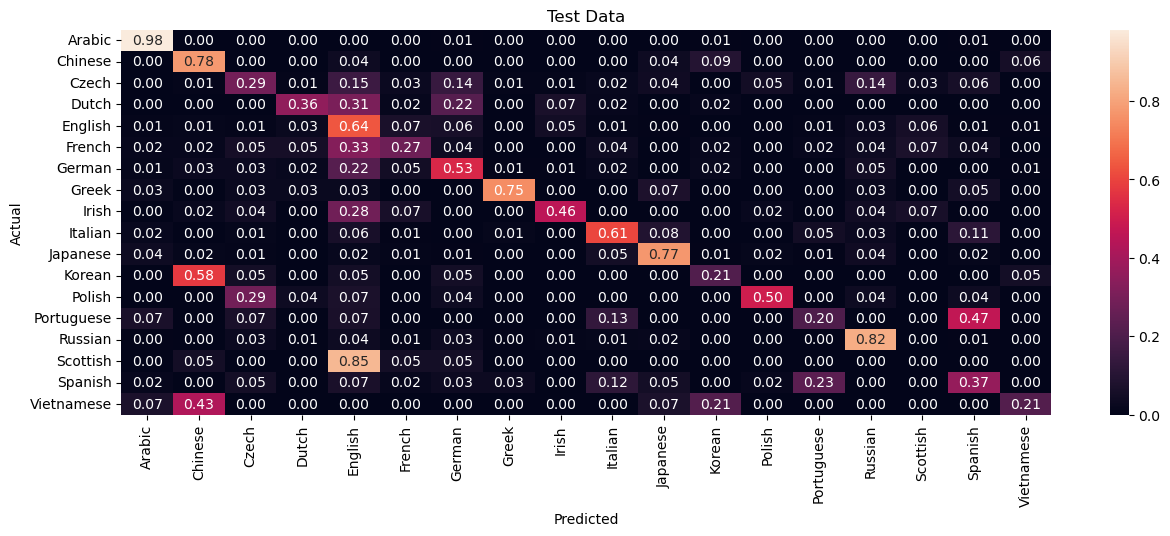

In [52]:
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
c_mat_test = c_mat_test / c_mat_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,5))
sns.heatmap(c_mat_test, annot=True, fmt="0.2f", xticklabels=labels, yticklabels=labels)
plt.title("Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
def compute_accuracies(c_mat):
    accuracies = c_mat / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k,v in zip(labels, accuracies)}
    return accuracies

In [54]:
compute_accuracies(c_mat_train)

{'Arabic': 0.9843750000000001,
 'Chinese': 0.8224299065420562,
 'Czech': 0.6385542168674699,
 'Dutch': 0.7857142857142857,
 'English': 0.7119972733469667,
 'French': 0.8243243243243243,
 'German': 0.7841105354058723,
 'Greek': 0.9877300613496932,
 'Irish': 0.7903225806451613,
 'Italian': 0.8218694885361552,
 'Japanese': 0.9079445145018915,
 'Korean': 0.68,
 'Polish': 0.8918918918918919,
 'Portuguese': 0.9491525423728814,
 'Russian': 0.8603507839489767,
 'Scottish': 0.6875000000000001,
 'Spanish': 0.7226890756302521,
 'Vietnamese': 0.4576271186440678}

In [55]:
compute_accuracies(c_mat_test)

{'Arabic': 0.9825,
 'Chinese': 0.7777777777777778,
 'Czech': 0.28846153846153844,
 'Dutch': 0.3559322033898305,
 'English': 0.6362397820163488,
 'French': 0.2727272727272727,
 'German': 0.5310344827586206,
 'Greek': 0.75,
 'Irish': 0.45652173913043476,
 'Italian': 0.6056338028169015,
 'Japanese': 0.7727272727272727,
 'Korean': 0.21052631578947367,
 'Polish': 0.5000000000000001,
 'Portuguese': 0.2,
 'Russian': 0.8230605738575983,
 'Scottish': 0.0,
 'Spanish': 0.36666666666666664,
 'Vietnamese': 0.21428571428571427}